## Overview

This attempts to describe kernels. The hope is after going through this, the reader appreciates just how powerful kernels are, and the role they play in Gaussian process models. 

In [52]:
### Data 
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px
import numpy as np
import pandas as pd
import plotly.io as pio
import numpy as np
pio.renderers.default = 'iframe'
from IPython.display import display, HTML

### Minimum norm solutions

One way to motivate the study of kernels, is to consider a linear regression problem where one has more unknowns than observational data. Let $\mathbf{X} = \left[\mathbf{x}_{1}^{T}, \mathbf{x}_{2}^{T}, \ldots, \mathbf{x}_{N}^{T}\right]$ be the $N \times d$ data corresponding to $N$ observations of $d$-dimensional data. These *input* observations are accompanied by an output observational vector, $\mathbf{y} \in \mathbb{R}^{N}$. Let $\boldsymbol{\Phi} \left( \mathbf{X} \right) \in \mathbb{R}^{N \times M}$ be a parameterized matrix comprising of $M$ basis functions, i.e., 

$$
\boldsymbol{\Phi}\left( \mathbf{X} \right) = \left[\begin{array}{cccc}
\phi_{1}\left(\mathbf{X} \right), & \phi_{2}\left(\mathbf{X} \right), & \ldots, & \phi_{M}\left(\mathbf{X} \right)\end{array}\right]
$$

If we are interested in approximating $f \left( \mathbf{X} \right) \approx \hat{f} \left( \mathbf{X} \right) = y = \mathbf{\Phi} \left( \mathbf{X} \right) \boldsymbol{\alpha}$, we can determine the unknown coefficients via least squares. This leads to the solution via the normal equations

$$
\boldsymbol{\alpha} = \left( \mathbf{\Phi}^{T} \mathbf{\Phi}\right)^{-1} \boldsymbol{\Phi}^{T} \mathbf{y}
$$

Now, strictly speaking, one cannot use the normal equations to solve a problem where there are more unknowns than observations because $\left( \mathbf{\Phi}^{T} \mathbf{\Phi}\right)$ is not full rank. Recognizing that in such a situation, there may likely be numerous solutions to $\boldsymbol{\Phi}\left( \mathbf{X} \right) \boldsymbol{\alpha} = \mathbf{y}$, we want the solution with the lowest $L_2$ norm. This can be more conveniently formulated as as *minimum norm problem*, written as

$$
\begin{aligned}
\underset{x}{\textrm{minimize}} & \; \boldsymbol{\alpha}^{T} \boldsymbol{\alpha} \\ 
\textrm{subject to} \; \; &  \boldsymbol{\Phi}\left( \mathbf{X} \right) \boldsymbol{\alpha} = \mathbf{y}.
\end{aligned}
$$

The easiest way to solve this via the method of Lagrange multipliers, i.e., we define the objective function 

$$
L \left( \boldsymbol{\alpha}, \lambda \right) = \boldsymbol{\alpha}^{T} \boldsymbol{\alpha}  + \lambda^{T} \left( \boldsymbol{\Phi}\left( \mathbf{X} \right) \boldsymbol{\alpha} - \mathbf{y}\right), 
$$

where $\lambda$ comprises the Lagrange multipliers. The optimality conditions for this objective are given by

$$
\begin{aligned}
\nabla_{\boldsymbol{\alpha}} L & = 2 \boldsymbol{\alpha} + \boldsymbol{\Phi}^{T} \lambda = 0, \\
\nabla_{\lambda} L & = \boldsymbol{\Phi} \boldsymbol{\alpha} - \mathbf{y} = 0. 
\end{aligned}
$$

This leads to $\boldsymbol{\alpha} = - \boldsymbol{\Phi}^{T} \lambda / 2$. Substituting this into the second expression above yields $\lambda = -2 \left(\boldsymbol{\Phi} \boldsymbol{\Phi}^{T} \right)^{-1} \mathbf{y}$. This leads to the minimum norm solution

$$
\boldsymbol{\alpha} = \boldsymbol{\Phi}^{T}  \left( \boldsymbol{\Phi} \boldsymbol{\Phi}^{T}  \right)^{-1} \mathbf{y}.
$$

Note that unlike $\left( \boldsymbol{\Phi}^{T} \boldsymbol{\Phi} \right)$, $\left( \boldsymbol{\Phi} \boldsymbol{\Phi}^{T}  \right)$ does have full rank. The latter is an inner product between feature vectors. To see this, define the two-point kernel function

$$
k \left( \mathbf{x}, \mathbf{x}' \right) = \boldsymbol{\Phi} \left( \mathbf{x} \right) \boldsymbol{\Phi}^{T} \left( \mathbf{x} \right). 
$$

and the associated covariance matrix, defined elementwise via

$$
\left[ \mathbf{K} \left(\mathbf{X}, \mathbf{X}' \right)\right]_{ij} = k \left( \mathbf{x}_{i}, \mathbf{x}_{j} \right)
$$

### The kernel trick (feature maps $\rightarrow$ kernels)

From the coefficients $\boldsymbol{\alpha}$ computed via the minimum norm solution, it should be clear that approximate values of the true function at new locations $\mathbf{X}_{\ast}$ can be given via

$$
\begin{aligned}
\hat{f} \left( \mathbf{X}_{\ast} \right) & = \Phi \left( \mathbf{X}_{\ast} \right) \boldsymbol{\alpha} \\
& = \boldsymbol{\Phi} \left( \mathbf{X}_{\ast} \right)  \boldsymbol{\Phi}^{T} \left( \mathbf{X} \right)  \left( \boldsymbol{\Phi} \left( \mathbf{X} \right)  \boldsymbol{\Phi}^{T} \left( \mathbf{X} \right)   \right)^{-1} \mathbf{y} \\
& = \left( \boldsymbol{\Phi} \left( \mathbf{X}_{\ast} \right)  \boldsymbol{\Phi}^{T} \left( \mathbf{X} \right)  \right)  \left( \boldsymbol{\Phi} \left( \mathbf{X} \right)  \boldsymbol{\Phi} \left( \mathbf{X} \right) ^{T}  \right)^{-1} \mathbf{y} \\
& = \mathbf{K} \left( \mathbf{X}_{\ast}, \mathbf{X} \right) \mathbf{K}^{-1} \left( \mathbf{X}, \mathbf{X} \right) \mathbf{y} \\
\end{aligned}
$$

There are two points to note here:

- The form of the expression above is exactly that of the posterior predictive mean of a noise-free Gaussian processes model.
- One need not compute the full $N \times M$ feature matrix $\boldsymbol{\Phi} \left( \mathbf{X} \right)$ explictly to work out the $N \times N$ matrix $\mathbf{K}\left( \mathbf{X}, \mathbf{X} \right)$. 

This latter point is why this is called the *kernel trick*, i.e., for a very large number of features $M >> N$ (possibly infinite), it is more computationally efficient to work out $\mathbf{K}$. 

Another way to interpret the kernel trick is to consider the example that was discussed in lecture with regards to the data in the plot below.  

#### A lifting analogy

Consider a quadratic kernel in $\mathbb{R}^{2}$, where $\mathbf{x} = \left(x_1, x_2 \right)^{T}$ and $\mathbf{v} = \left(v_1, v_2 \right)^{T}$. We can express this kernel as
$$
\begin{aligned}
k \left( \mathbf{x}, \mathbf{v} \right) =  \left( \mathbf{x}^{T}  \mathbf{v} \right)^2 & = \left( \left[\begin{array}{cc}
x_{1} & x_{2}\end{array}\right]\left[\begin{array}{c}
v_{1}\\
v_{2}
\end{array}\right] \right)^2  \\
& = \left( x_1^2 v_1^2 + 2 x_1 x_2 v_1 v_2 + x_2^2 v_2^2\right) \\
& = \left[\begin{array}{ccc}
x^2_{1} & \sqrt{2} x_1 x_2 & x_2^2 \end{array}\right]\left[\begin{array}{c}
v_{1}^2\\
\sqrt{2}v_1 v_2 \\
v_{2}^2 
\end{array}\right] \\
& = \phi \left( \mathbf{x} \right)^{T} \phi \left( \mathbf{v}  \right).
\end{aligned}
$$
where $\phi \left( \cdot \right) \in \mathbb{R}^{3}$. 

Now lets tabulate the number of operations required depending on which route one takes. Computing $\left( \mathbf{x}^{T}  \mathbf{v} \right)^2$ requires two multiplications (i.e., $x_1 \times v_1$ and $x_2 \times v_2$), one sum (i.e., $s = x_1 v_1 + x_2 v_2$), and one product (i.e., $s^2$). This leads to a total of four operations. 

Now consider the number of operations required for computing $ \phi \left( \mathbf{x} \right)^{T} \phi \left( \mathbf{v}  \right)$. Assembling $\phi \left( \mathbf{x} \right)$ itself requires three products; multiplying by $\phi \left( \mathbf{v} \right)$ incurs another three products leading to a total of 10 operations (9 multiplications and one sum). Thus, computationally, it is cheaper to use the original form for calculating the product.

There is however another perspective to this. Data that is not linearly separable in $\mathbb{R}^{2}$ can be *lifted* up to $\mathbb{R}^{3}$ where a separation may be more easily inferred. In this particular case, $\phi \left( \mathbf{x} \right)$ takes the form of a polynomial kernel. 


To visualize this consider a red and green set of random points within a circle. Points that have a relatively greater radius are shown in red, whilst points that are closer to the center are captured in green. 

In [53]:
t = np.random.rand(40,1)* 2 * np.pi
r = np.random.rand(40,1)*0.2 + 2
u = r * np.cos(t)
v = r * np.sin(t)

xy = np.vstack([np.random.rand(20,2)*2 - 1])
xy2 = np.hstack([u, v])

In [54]:
fig = go.Figure()
fig.add_scatter(x=xy2[:,0], y=xy2[:,1],  name='Red', mode='markers', marker=dict(
        size=15, color='red', opacity=0.8, line=dict(color='black', width=1) ))
fig.add_scatter(x=xy[:,0], y=xy[:,1],  name='Green', mode='markers', marker=dict(
        size=15, color='green', opacity=0.8, line=dict(color='black', width=1) ))
fig.update_layout(legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
                  xaxis_title=r'$\mathbf{x}$',yaxis_title=r'$\mathbf{v}$')

fig.show()

It is not possible to separate these two sets using a line (or more generally a hyperplane). However, when the same data is lifed to $\mathbb{R}^{3}$, the two sets are linearly separable. 

In [55]:
def mapup(xy):
    phi_1 = xy[:,0]**2
    phi_2 = np.sqrt(2) * xy[:,0] * xy[:,1]
    phi_3 = xy[:,1]**2
    return phi_1, phi_2, phi_3

z1, z2, z3 = mapup(xy2)
w1, w2, w3 = mapup(xy)

In [56]:
fig = go.Figure()
fig.add_scatter3d(x=z1, y=z2, z=z3, name='Red', mode='markers', marker=dict(
        size=10, color='red', opacity=0.8, line=dict(color='black', width=2) ))
fig.add_scatter3d(x=w1, y=w2, z=w3, name='Green', mode='markers', marker=dict(
        size=10, color='green', opacity=0.8, line=dict(color='black', width=2) ))
fig.update_layout(legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
                  scene = dict(
                    xaxis_title=r'$\phi_{1}$',
                    yaxis_title=r'$\phi_2$',
                    zaxis_title=r'$\phi_3$'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

### Mercer's theorem (kernels $\rightarrow$ feature maps)

Now, we shall be interested in mapping from a kernel to a feature map. This leads us to **Mercer's theorem**, which states that: *A symmetric function $k \left( \mathbf{x}, \mathbf{x}' \right)$  can be expressed as the inner product*

$$
k \left( \mathbf{x}, \mathbf{x}' \right) = \phi \left( \mathbf{x} \right) \phi^{T} \left( \mathbf{x}'\right) = \left\langle \phi \left( \mathbf{x} \right), \phi\left( \mathbf{x}' \right) \right\rangle 
$$

for some feature map $\phi$ if and only if $k \left( \mathbf{x}, \mathbf{x}' \right)$ is positive semidefinite, i.e.,

$$
\int k \left( \mathbf{x}, \mathbf{x}' \right) g \left(  \mathbf{x} \right)  g \left(  \mathbf{x}' \right) d \mathbf{x} d \mathbf{x}' \geq 0 
$$

for all $g$. Another way to equivalent express this is the matrix $\mathbf{K}\left( \mathbf{X}, \mathbf{X}' \right)$ is positive semi-definite for any collection of $\mathbf{X}$. One can therefore write its eigendecomposition

$$
\mathbf{K} = \mathbf{V} \boldsymbol{\Lambda} \mathbf{V}^{T}
$$

where $\mathbf{V}$ is a matrix of formed by the eigenvectors of $\mathbf{K}$ and $\boldsymbol{\Lambda}$ is a diagonal matrix of its eigenvalues, i.e.,

$$
\mathbf{V} = \left[\begin{array}{cccc}
| & | &  & |\\
\mathbf{v}_{1} & \mathbf{v}_{2} & \ldots & \mathbf{v}_{N}\\
| & | &  & |
\end{array}\right], \; \; \; \; \textrm{and} \; \; \; \; \boldsymbol{\Lambda}=\left[\begin{array}{cccc}
\lambda_{1}\\
 & \lambda_{2}\\
 &  & \ddots\\
 &  &  & \lambda_{N}
\end{array}\right],
$$

where $\lambda_1 \leq \lambda_2 \geq \ldots \lambda_{N} \geq 0$. This expansion permits one to express each element of $\mathbf{K}$ as

$$
\mathbf{K}_{ij} = \left( \sqrt{\lambda_{i}} \mathbf{v}_{i} \right)^{T} \left(  \sqrt{\lambda_{j}} \mathbf{v}_{j}\right). 
$$

More generally, if we define eigenfunctions of the form $\gamma \left( \mathbf{x} \right) = \sqrt{\lambda} \mathbf{v}$, then we have

$$
k \left( \mathbf{x}, \mathbf{x}' \right) = \gamma \left( \mathbf{x} \right)^{T} \gamma \left( \mathbf{x} \right). 
$$

To summarize, what Mercer's theorem tells us is that one can either map from 

$$
\mathbf{x} \rightarrow \phi \left( \mathbf{x} \right) \rightarrow k \left( \mathbf{x}, \mathbf{x}' \right)$$

explciitly, or implicitly go from 

$$
\mathbf{x} \rightarrow k \left( \mathbf{x}, \mathbf{x}' \right)
$$

without knowledge of the feature map $\phi$.

#### The case of infinitely many feature vectors

We shall now briefly consider the case of regression with infinitely many functions. Consider a basis function of the form

$$
\boldsymbol{\Phi}\left( \mathbf{x} \right) = \left[\begin{array}{cccc}
\phi_{1}\left(\mathbf{x} \right), & \phi_{2}\left(\mathbf{x} \right), & \ldots, & \phi_{\infty}\left(\mathbf{x} \right)\end{array}\right]
$$

where 

$$
\phi_{j}\left( \mathbf{x} \right) = exp \left( - \frac{\left( \mathbf{x} - c_j \right)^2 }{2l^2} \right)
$$

where $c_j$ represents the center of the bell-shaped basis function; we assume that there are infinitely many centers across the domain of interest and thus there exists infinitely many basis terms. To visualize this, see the code below.

In [72]:
x = np.linspace(-5, 5, 150)
infty_subtitute = 20
c_js = np.linspace(-5, 5, infty_subtitute)
l = 0.5

fig = go.Figure()
for j in range(0, infty_subtitute):
    leg = 'c_j = '+str(np.around(c_js[j], 2))
    psi_j = np.exp(- (x - c_js[j])**2 * 1./(2*l**2))
    fig.add_scatter(x=x, y=psi_j, mode='lines', name=leg)
    fig.update_layout(legend=dict(yanchor="top", y=0.99, xanchor="left", x=-0.6),
                  xaxis_title=r'$x$',yaxis_title=r'$\phi\left( x \right)$')
fig.show()

The two-point covariance matrix can be written as a sum of rank-one matrices, i.e.,

$$
\begin{aligned}
\mathbf{K} & = \boldsymbol{\Phi}\left( \mathbf{x} \right)\boldsymbol{\Phi}^{T} \left( \mathbf{X} \right) \\
& = \sum_{j=1}^{\infty} \phi_{j}\left( \mathbf{X} \right) \phi_{j}^{T}\left( \mathbf{X}' \right) 
\end{aligned}
$$

or if one is considering each kernel entry, one can write

$$
\begin{aligned}
\mathbf{K}_{ij}  & = k \left( \mathbf{x}_i, \mathbf{x}_j \right)\\
& = \boldsymbol{\Phi}\left( \mathbf{x}_i \right)\boldsymbol{\Phi}^{T} \left( \mathbf{x}_j \right) \\
& = \sum_{p=1}^{\infty} \phi_{p}\left( \mathbf{x}_i \right) \phi_{p}\left( \mathbf{x}_j \right) 
\end{aligned}
$$

This last expression can be conveniently replaced with an integral (see RW page 84).

$$
k \left( \mathbf{x}_i, \mathbf{x}_j \right)  = \int_{\mathcal{X}} exp \left( - \frac{\left( \mathbf{x}_i - c \right)^2 }{2l^2} \right)exp \left( - \frac{\left( \mathbf{x}_j - c \right)^2 }{2l^2} \right)dc
$$

where we will assume that $\mathcal{X} \subset [-\infty, \infty]$. This leads to 

$$
\begin{aligned}
k \left( \mathbf{x}_i, \mathbf{x}_j \right) & = \int_{-\infty}^{\infty} exp \left( - \frac{\left( \mathbf{x}_i - c \right)^2 }{2l^2} \right)exp \left( - \frac{\left( \mathbf{x}_j - c \right)^2 }{2l^2} \right)dc \\
& = \sqrt{\pi}l \; exp \left( - \frac{\left(\mathbf{x}_i - \mathbf{x}_j\right)^2 }{2 \left( \sqrt{2} \right) l^2 } \right).
\end{aligned}
$$

The last expression is easily recognizable as an RBF kernel with an amplitude of $\sqrt{\pi}l$ and a slightly amended length scale of $\sqrt{2}l^2$. It is straightforward to adapt this to multivariate $\mathbf{x}$. 

<mark>Note the utility of this representation---we essentially have infinitely many basis terms, but the size of our covariance matrix is driven by the number of data points</mark>

### Bochner's theorem

A stationary function $k \left( \mathbf{x}, \mathbf{x}' \right) =k \left( \mathbf{x} - \mathbf{x}' \right) = k \left( \boldsymbol{\tau} \right) $ can be represented as the Fourier transform of a positive finite measure. The formal statement is given by

*A complex-valued function $k$ on $\mathcal{X}$ is the covariance function of a weakly stationary mean square continuous complex-valued random process on $\mathcal{X}$ if and only if it can be represented as*

$$
k \left( \boldsymbol{\tau} \right) = \int_{\mathcal{X}} exp \left( 2 \pi i \boldsymbol{\omega} \cdot \boldsymbol{\tau} \right) d \mu \left( \boldsymbol{\omega} \right) 
$$

where $\mu$ is a positive finite measure, and $\boldsymbol{\omega}$ are the frequencies. If $\mu$ has a density $S \left( \boldsymbol{\omega} \right)$, then $S$ is the **spectral density** or **power spectrum** associated with the kernel $k$. 

### Wiener-Khintchine theorem

A direct consequence of Bochner's theoreom is the Wiener-Khintchine theorem. If the spectral density $S \left( \boldsymbol{\omega} \right)$ exists, the spectral density and the covariance function are said to be *Fourier duals*. This leads to the following statement:

$$
k \left( \boldsymbol{\tau} \right) = \int S \left( \boldsymbol{\omega} \right) exp \left( 2 \pi i \boldsymbol{\omega} \cdot \boldsymbol{\tau} \right) d \boldsymbol{\omega}, \; \; \; \; S \left( \boldsymbol{\omega}\right) = \int k \left( \boldsymbol{\tau} \right) exp\left(- 2 \pi i \boldsymbol{\omega} \cdot \boldsymbol{\tau} \right) d \boldsymbol{\tau}
$$


As noted in RW, $S \left( \boldsymbol{\omega} \right)$ is essentially the amount of power assigned to the eigenfunction $exp \left( 2 \pi i \boldsymbol{\omega} \cdot \mathbf{\tau} \right)$ with frequency $\boldsymbol{\omega}$. The amplitude as a function of frequency $S\left( \boldsymbol{\omega} \right)$ must decay sufficiently fast so that the terms above are integrable. 

There are some important points to note:

1. If we have a stationary kernel, we can resolve what frequencies underscore the model by working out its Fourier transform.
2. On the other hand, if we have a certain spectral density of interest, then its inverse Fourier transform is a kernel. 

To analytically work this out, it may be useful to go through an example (courtsey of Markus Heinonen). The derivation below will require three pieces:
- We shall assume a symmetric frequency distribution, i.e., $S\left( \boldsymbol{\omega} \right) = S \left( -\boldsymbol{\omega} \right)$. 
- From Euler's formula we have $cos\left(x\right) \pm i sin\left(x \right) = exp \left(\pm ix \right)$
- The negative sine identity, i.e., $sin \left( -x \right) = - sin \left( x \right)$


Starting with the expression above, we begin wtih

$$
\begin{aligned}
k \left( \boldsymbol{\tau} \right) & = \int_{-\infty}^{\infty} S \left( \boldsymbol{\omega} \right) exp \left( 2 \pi i \boldsymbol{\omega} \cdot \boldsymbol{\tau} \right) d \boldsymbol{\omega} \\
& =   \int_{-\infty}^{\infty} S \left(\boldsymbol{\omega} \right) cos \left( 2 \pi\boldsymbol{\tau} \cdot \boldsymbol{\omega} \right) d \boldsymbol{\omega} + \int_{-\infty}^{\infty} iS \left(\boldsymbol{\omega} \right) sin \left( 2 \pi \boldsymbol{\tau} \cdot \boldsymbol{\omega} \right) d \boldsymbol{\omega} \\
& = \mathbb{E}\left[ S \left(\omega \right) \right] cos \left( 2 \pi \boldsymbol{\tau} \cdot \boldsymbol{\omega} \right)  + \int_{-\infty}^{0} iS \left(\boldsymbol{\omega} \right) sin \left( 2 \pi \boldsymbol{\tau} \cdot \boldsymbol{\omega} \right) d \boldsymbol{\omega} + \int_{0}^{\infty} iS \left(\boldsymbol{\omega} \right) sin \left( 2 \pi \boldsymbol{\tau} \cdot \boldsymbol{\omega} \right) d \boldsymbol{\omega} \\
& = \mathbb{E}\left[ S \left(\omega \right) \right] cos \left( 2 \pi \boldsymbol{\tau} \cdot \boldsymbol{\omega} \right)  + \int_{0}^{\infty} iS \left(-\boldsymbol{\omega} \right) sin \left( -2 \pi \boldsymbol{\tau} \cdot \boldsymbol{\omega} \right) d \boldsymbol{\omega} + \int_{0}^{\infty} iS \left(\boldsymbol{\omega} \right) sin \left( 2 \pi \boldsymbol{\tau} \cdot \boldsymbol{\omega} \right) d \boldsymbol{\omega} \\
& = \mathbb{E}\left[ S \left(\omega \right) \right] cos \left( 2 \pi \boldsymbol{\tau} \cdot \boldsymbol{\omega} \right)  + \int_{0}^{\infty} -iS \left(\boldsymbol{\omega} \right) sin \left( 2 \pi \boldsymbol{\tau} \cdot \boldsymbol{\omega} \right) d \boldsymbol{\omega} + \int_{0}^{\infty} iS \left(\boldsymbol{\omega} \right) sin \left( 2 \pi \boldsymbol{\tau} \cdot \boldsymbol{\omega} \right) d \boldsymbol{\omega} \\
\end{aligned}
$$

This leads to 

$$
\begin{aligned}
k \left( \boldsymbol{\tau} \right) & = \mathbb{E}\left[ S \left(\omega \right) \right] cos \left( 2 \pi \boldsymbol{\tau} \cdot \boldsymbol{\omega} \right)   
\end{aligned}
$$

<mark>This demonstrates that all real-valued stationary kernels are $S\left( \boldsymbol{\omega} \right)$-weighted combinations of cosine terms. </mark>

### Kernel harmonic representation

Our new general stationary kernel definition is thus:

$$
k \left( \boldsymbol{\tau} \right)  = \mathbb{E}\left[ S \left(\omega \right) \right] cos \left( 2 \pi \boldsymbol{\tau} \cdot \boldsymbol{\omega} \right)   
$$
    
where the frequencies $\boldsymbol{\omega}$ are an inverse of the period $1/\boldsymbol{\omega}$. Bracewell provides the following expressions for the Wiener-Khintchine result, by integrating out the angular variables (see page 83 of RW):

$$
\begin{aligned}
k \left( \boldsymbol{\tau} \right) & = \frac{2 \pi}{\boldsymbol{\tau}^{-1/2}} \int_{0}^{\infty} S \left( \boldsymbol{\omega} \right) J_{-1/2} \left(2 \pi  \boldsymbol{\tau} \cdot \boldsymbol{\omega} \right) \boldsymbol{\omega}^{1/2} d \boldsymbol{\omega} \\
S \left(   \boldsymbol{\omega} \right) & = \frac{2 \pi}{\boldsymbol{\omega}^{-1/2}} \int_{0}^{\infty} k \left( \boldsymbol{\tau} \right) J_{-1/2} \left(2 \pi  \boldsymbol{\tau} \cdot \boldsymbol{\omega} \right) \boldsymbol{\tau}^{1/2} d \boldsymbol{\tau}
\end{aligned}
$$

Note that in RW, the authors use $D$ to denote the dimensionality, which we have assumed to be 1. The function $J_{-1/2}$ is the Bessel function of order $-1/2$. While the expressions above may seem unwiedly, we can work out what these are using a bit of ``Sympy``. Consider the case of a squared exponential kernel of the form

$$
k \left(\boldsymbol{\tau} \right) = exp \left(- \frac{\boldsymbol{\tau}^2}{2l^2} \right).
$$

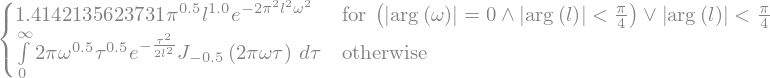

In [126]:
from sympy import * 

omega = Symbol("omega")
ell = Symbol("l")
tau = Symbol("tau")

kernel = exp(- tau**2 / (2 * ell**2))
integrate(2*pi*omega**(1/2) * kernel * besselj(-1/2, 2*pi*tau*omega)*tau**(1/2), (tau, 0, oo))

The first expression above is the Fourier amplitude of the squared exponential kernel, i.e.,

$$
S \left(   \boldsymbol{\omega} \right) = \left( 2 \pi l^2\right)^{1/2} exp \left( - 2 \pi l^2 \boldsymbol{\omega}^2 \right)
$$


In [143]:
omega = np.linspace(0, np.pi/4, 50)
l = 0.5
S_omega = (2 * np.pi * l**2)**(1/2) * \
            np.exp(- 2 * np.pi * l**2 * omega**2)
tau = np.linspace(0, 10, 200)


fig = go.Figure()
fig.add_scatter(x=omega, y=S_omega, mode='lines')
fig.update_layout(title='Spectral density', \
                  xaxis_title=r'Frequency, $\omega$',\
                  yaxis_title=r'Spectral density, $S\left( \omega \right) $')
fig.show()

In [152]:
kernel = tau * 0.
true_kernel = np.exp(-tau**2 / l**2)
counter = 0.

fig = go.Figure()
for omega_j in omega:
    counter += 1.
    label=str(np.around(int(counter), 1))+' terms'
    S_omega_j = (2 * np.pi * l**2)**(1/2) * \
            np.exp(- 2 * np.pi * l**2 * omega_j**2)
    cos_term = np.cos(2 * np.pi * tau * omega_j)
    kernel += (S_omega_j * cos_term)
    fig.add_scatter(x=tau, y=kernel * 1/counter, name=label, mode='lines')
fig.add_scatter(x=tau, y=true_kernel, name='Kernel', mode='lines', \
                line=dict(width=4, color='black'))
fig.update_layout(title='Sq. exp kernel Fourier representation', \
                  xaxis_title=r'Distance, $\tau$',\
                  yaxis_title=r'$k ( \tau )$')
fig.show()

Notice that the more terms we incorporate, the closer we converge to the true kernel. 

### References

These notes use material from the following sources:
    
1. [Jordan, M., *The Kernel Trick*](https://people.eecs.berkeley.edu/~jordan/courses/281B-spring04/lectures/lec3.pdf)

2. [Gundersen, G., *Implicit Lifting and the Kernel Trick*](https://gregorygundersen.com/blog/2019/12/10/kernel-trick/)